## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="C:/Users/loe_lin/Desktop/Machine learning/Day086/tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )
model.save("final_model.h5")
model.save_weights("model_weights.h5")
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

pred_final = model.predict(x_test)
# Load back
model = keras.models.load_model("C:/Users/loe_lin/Desktop/Machine learning/Day086/tmp.h5")
pred_loadback = model.predict(x_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 512)               0         
_________________________________________________________________
tf.__operators__.add (TFOpLa (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
tf.math.multiply_1 (TFOpLamb (None, 256)               0         
_________________________________________________________________
tf.__operators__.add_1 (TFOp (None, 256)               0     

C:\Users\loe_lin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
49/49 [==============================] - 2s 41ms/step - loss: 2.2229 - accuracy: 0.1797 - val_loss: 2.1143 - val_accuracy: 0.2504
Epoch 2/50
49/49 [==============================] - 2s 38ms/step - loss: 2.0334 - accuracy: 0.2825 - val_loss: 1.9722 - val_accuracy: 0.3025
Epoch 3/50
49/49 [==============================] - 2s 39ms/step - loss: 1.9308 - accuracy: 0.3190 - val_loss: 1.8986 - val_accuracy: 0.3339
Epoch 4/50
49/49 [==============================] - 2s 36ms/step - loss: 1.8725 - accuracy: 0.3451 - val_loss: 1.8528 - val_accuracy: 0.3513
Epoch 5/50
49/49 [==============================] - 2s 41ms/step - loss: 1.8330 - accuracy: 0.3593 - val_loss: 1.8191 - val_accuracy: 0.3617
Epoch 6/50
49/49 [==============================] - 2s 45ms/step - loss: 1.8023 - accuracy: 0.3693 - val_loss: 1.7931 - val_accuracy: 0.3721
Epoch 7/50
49/49 [==============================] - 2s 45ms/step - loss: 1.7772 - accuracy: 0.3781 - val_loss: 1.7691 - val_accuracy: 0.3850
Epoch 8/50
49

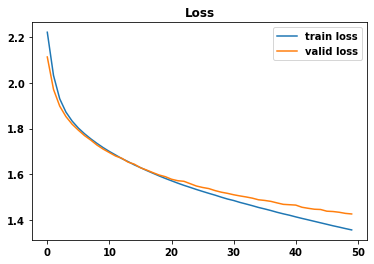

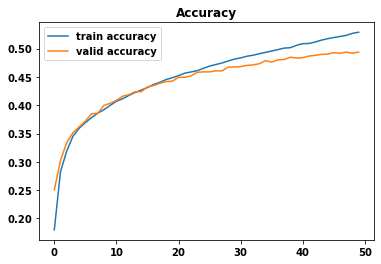

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [9]:
from sklearn.metrics import accuracy_score

final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_final.argmax(axis=-1))
loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=pred_loadback.argmax(axis=-1))

print("Accuracy of final weights: %.3f" % final_model_acc)
print("Accuracy of best weights: %.3f" % loadback_acc)

Accuracy of final weights: 0.494
Accuracy of best weights: 0.494


In [10]:
new_model = build_mlp(input_shape=x_train.shape[1:])
new_model_pred = new_model.predict(x_test)
new_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_acc)

new_model.load_weights("C:/Users/loe_lin/Desktop/Machine learning/Day086/model_weights.h5")
new_model_pred = new_model.predict(x_test)
new_model_loadback_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=new_model_pred.argmax(axis=-1))
print("Accuracy of best weights: %.3f" % new_model_loadback_acc)

Accuracy of best weights: 0.107
Accuracy of best weights: 0.494
